# `dPdI.ipynb`

Calculate dPdI from dIdV output, use to calculate NEP from PSD

In [1557]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st
import scipy.signal as sg


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [1558]:
folder_base = '/Users/ajbiffl/Documents/CDMS/oxford_fridge'

In [1559]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

required data inputs

In [1560]:
# read in results from IbIs analysis
#with open('./ibis_data/local/20241108-0001_results.dat', 'rb') as f:
#    ibis, ivfits, tr_fits = pickle.load(f)

if 1:
    with open(folder_base + '/Run4/dIdV Data/20250516_results.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'ABCD'
else:
    with open('C:/Users/MINER/Documents/B13 Cryolab/Run4/dIdV Data/20250516_results_doubled.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'ABCD'


with open(folder_base + '/Run4/dIdV Data/20250516_numerical_dpdi.dat', 'rb') as f:

    dpdi_num = pickle.load(f)

# needed for power spectrum of pulse
#psd_path = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/'
psd_path = folder_base + '/Run4/Analysis 0/'
template_path = folder_base + '/Run4/Analysis 0/'
template_path2 = folder_base + '/Run4/Analysis 0/'
#template_path = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/' # saturday
#template_path2 = 'E:/Run4/ContactFreeGe_ChsABCD_0V/Analysis 0/' # saturday


# needed for phonon collection efficiency calc

sumbcd = 1.54636e-8 # peak position in sum 


"""
run 3 numbers

saturday data, cutting D
A - 8.28e-7
C - 1.84e-6
D - 2.78e-6

saturday data, individual channel cuts
A - 1.433e-6
C - 2.816e-6
D - 2.827e-6

no PT (no cuts)
A - 4.5e-7
C - 7e-7
D - 9e-7

tuesday data
A - 3.13e-6 (cutting A)?
C - 2.41e-6 (cutting C)
D - 2.78e-6 (cutting D)

"""


# position of peaks in calibration (OF height where peak occurs)
peak_positions2 = { # idk
    'A': 2*9.98e-7,
    'B': 2*4.485e-7,
    'C': 2*2.844e-6, #6.47901e-8,
    'D': 2*5.458e-6, #5.42406e-8,
}

peak_positions = { # SSE and chi2 cut, full partition cuts
    'A': 2*4.34e-7,
    'B': 2*2.402e-7,
    'C': 2*1.131e-6, #6.47901e-8,
    'D': 2*1.39e-6, #5.42406e-8,
}


peak_energy = 59.54 # energy of peak (keV)

In [1561]:
for c in 'ABCD':
    print(c, didvfit[c][3]['params']['dt'])

A 1.396901390382064e-06
B 1.5189911081884275e-06
C 1.4378029673277097e-06
D 1.4441543964840635e-06


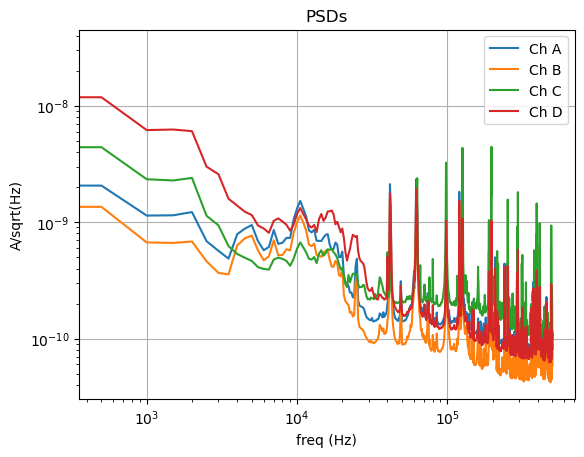

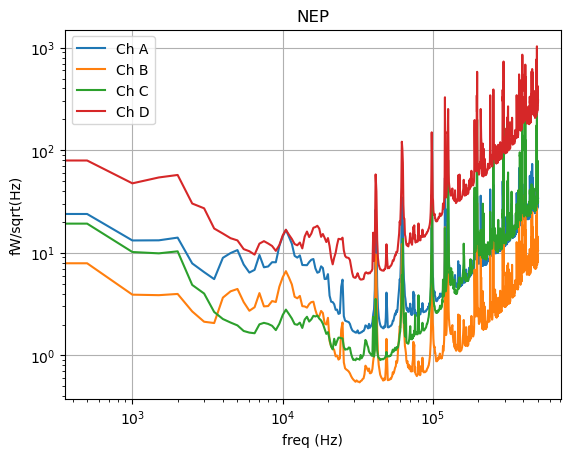

In [1562]:
# calculate NEP from PSD data and write to txt files

def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = 4*np.loadtxt(filename)
    fs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return fs, psd

fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')


dpdi = {}

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(fs, didvfit[chan][3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(fs, psd, label = f'Ch {chan}')
    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')


ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



Text(0, 0.5, 'dPdI')

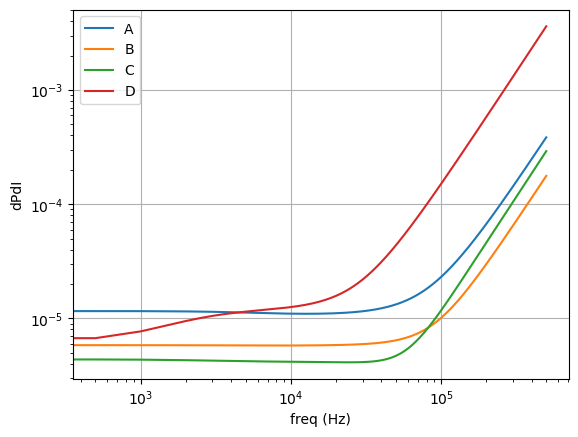

In [1563]:
plt.figure()
plt.loglog()
plt.grid()
for chan in channels:
    plt.plot(fs, abs(dpdi[chan]), label = chan)
    #plt.plot(fs, abs(dpdi_num[chan][:len(fs)]), label = chan)

plt.legend()
plt.xlabel('freq (Hz)')
plt.ylabel('dPdI')

In [1564]:
num_reslice = slice(N//2, N, 5)

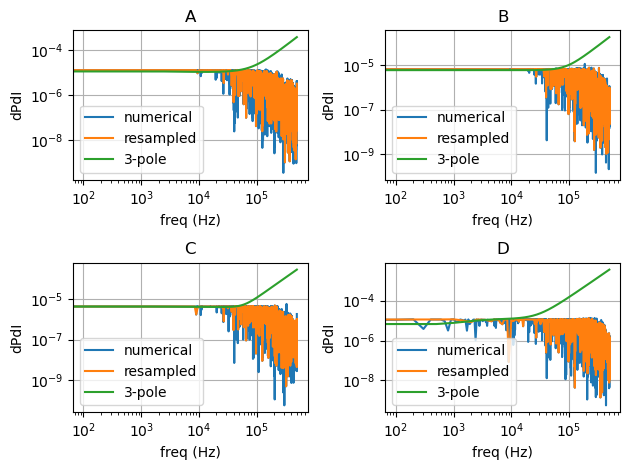

In [1565]:
fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    ax.loglog()
    ax.grid()
for chan, ax in zip(channels, axs.flatten()):
    ax.plot(dpdi_num['freq'][N//2:], abs(dpdi_num[chan])[N//2:], label = 'numerical')
    ax.plot(fs, abs(dpdi_num[chan][num_reslice]), label = 'resampled')
    wind = ax.axis()
    ax.plot(fs, abs(dpdi[chan]), label = '3-pole')
    #ax.axis(wind)
    ax.set_title(chan)
    ax.legend()

    #plt.legend()
    ax.set_xlabel('freq (Hz)')
    ax.set_ylabel('dPdI')

fig.tight_layout()

In [1566]:
fs.shape, dpdi_num['freq'].shape

if 0:
    for c in channels:
        dpdi[c] = dpdi_num[c][num_reslice]

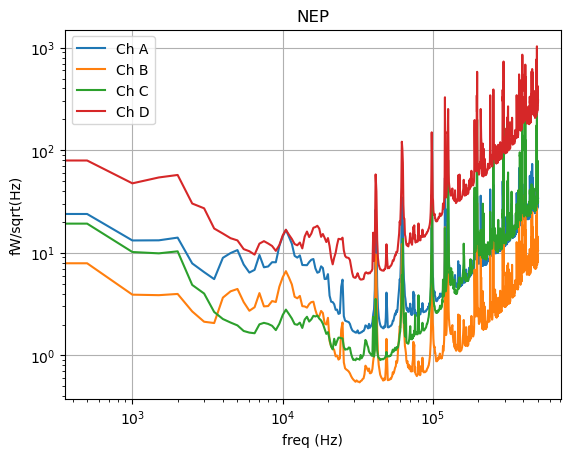

In [1567]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

#ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [1568]:
dpdi['A'].shape, psd.shape

((1000,), (1000,))

In [1569]:
# np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

In [1570]:
# get pulse templates

templates_unnorm = {}
templates = {}
templates2 = {}

for c in channels:

    templates_unnorm[c] = np.loadtxt(template_path + f'Templates 2/Ch {c} Template.txt')

    templates2[c] = templates_unnorm[c]/templates_unnorm[c].max()

    templates_unnorm2 = np.loadtxt(template_path2 + f'Ch {c} Average Templates.txt')

    templates[c] = templates_unnorm2/templates_unnorm2.max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates['A'].size, 1e-3) # templates = 2 ms traces

sampling_freq = templates['A'].size/2e-3 # Hz

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

In [1571]:
if 0:
    # butterworth filter at 50 kHz
    filter_order = 10
    filter_freq = 5e4 # Hz
    butt = sg.butter(N = filter_order, Wn = filter_freq, btype = 'lowpass', output = 'sos', fs = sampling_freq)

    for c in channels:
        templates[c] = sg.sosfilt(butt, templates[c])
        templates[c] /= templates[c].max()

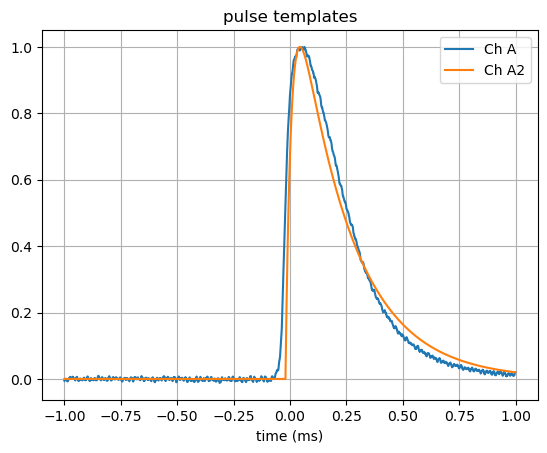

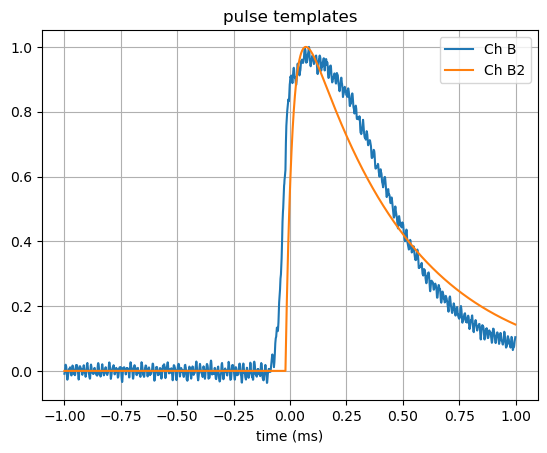

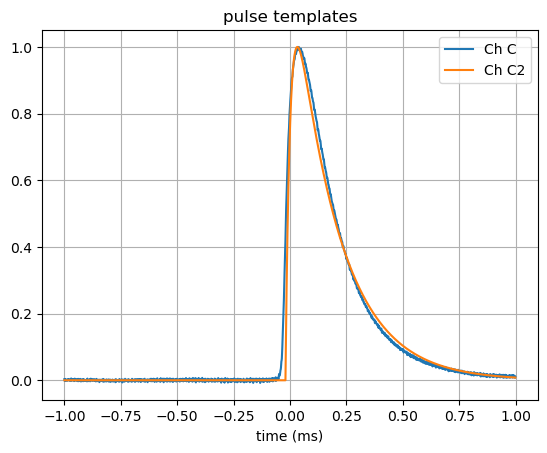

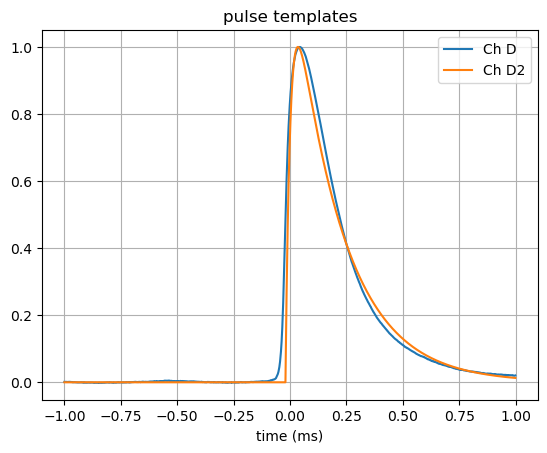

In [1572]:


for c in channels:
    plt.figure()
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

    #plt.axis((-0.2, 0.2, 0.5,1.1))
    plt.title('pulse templates')
    plt.grid()
    plt.legend()
    plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

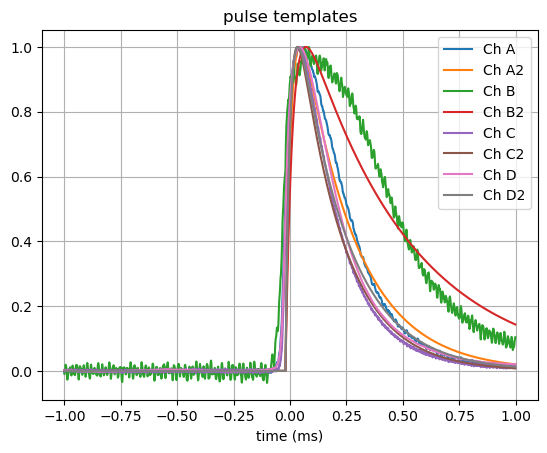

In [1573]:
plt.figure()

for c in channels:
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

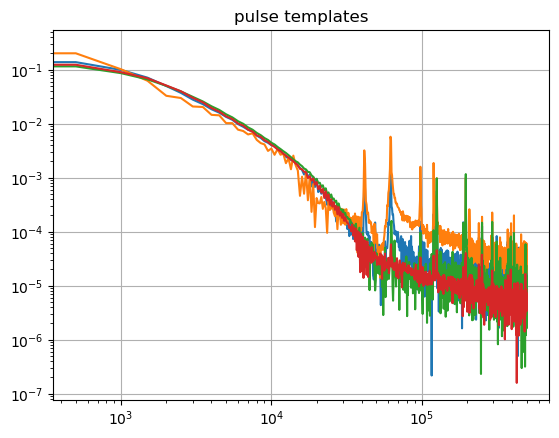

In [1574]:
plt.figure()

for c in channels:
    plt.plot(fs, abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [1575]:
# convert templates to frequency domain and convert to power
pulse_power = {}
pulse_power_num = {}

template_energy = {} # energy (keV) of template
template_energy_num = {}

edge_cut = 5

for c in channels:

    temp_w = of.fft(templates[c]) # template current frequencies

    #dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))
    dpdi_unfolded_num = np.hstack((abs(dpdi_num[c][num_reslice]), abs(dpdi_num[c][num_reslice])[::-1]))

    pow_w = temp_w*dpdi_unfolded # template power frequencies

    pulse_power[c] = of.ifft(pow_w) # template power
    pulse_power_num[c] = of.ifft(temp_w*dpdi_unfolded_num)

    template_energy[c] = float(np.trapz(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16) # energy of unit-height template in keV
    template_energy_num[c] = float(np.trapz(np.real(pulse_power_num[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16) # energy of unit-height template in keV
    

Text(0.5, 0, 'time (ms)')

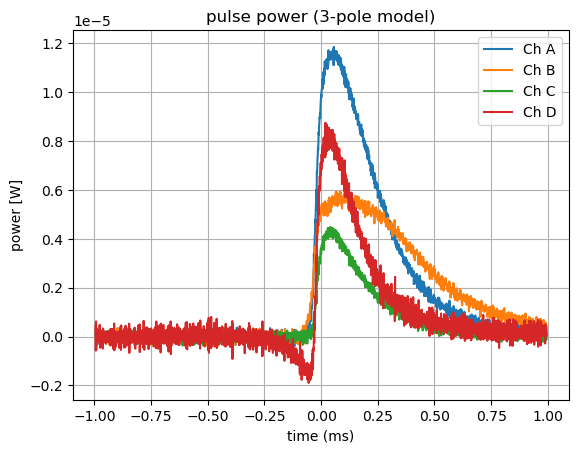

In [1576]:
plt.figure()

for c in channels:
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power (3-pole model)')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

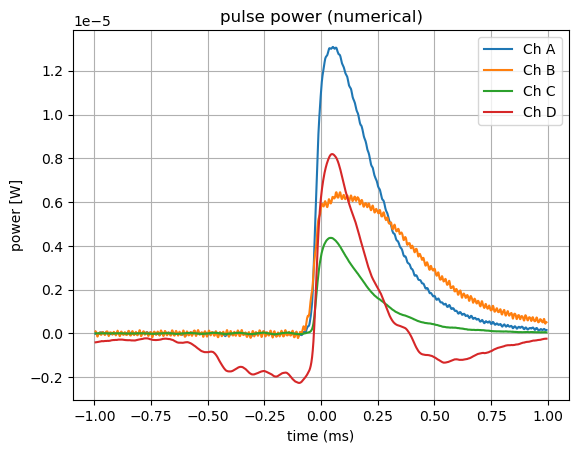

In [1577]:
plt.figure()

for c in channels:
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power_num[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power (numerical)')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [1578]:
template_energy

{'A': 23197361.45934579,
 'B': 19198028.258465137,
 'C': 7232128.787334532,
 'D': 11418760.355288133}

In [1579]:
template_energy_num

{'A': 26142222.96992047,
 'B': 21316735.902741507,
 'C': 7228468.259265683,
 'D': 1039507.6651475787}

In [1580]:
resolutions = {}
resolutions2 = {}
resolutions3 = {}

print('energy resolutions (phonon energy, ER energy)')

for c in channels:

    fs, psd = read_PSD(psd_path + f'PSD/Ch {c} PSD.txt', nsamples = 1000_000, trace_length = 1) # Hz, A/sqrt(Hz)

    nep = (abs(psd)*abs(dpdi[c]))**2 # W^2/Hz
    Jn = abs(psd)**2 # A^2/Hz

    resolutions[c] = of.resolution(templates[c]/templates[c].max(), np.hstack((Jn, Jn[::-1]))/2, 1.)*template_energy[c] # keV
    resolutions2[c] = of.resolution(templates[c]/templates[c].max(), np.hstack((Jn, Jn[::-1]))/2, 1.)*peak_energy/peak_positions[c] # keV

    #resolutions2[c] = of.resolution(np.real(pulse_power[c])/np.real(pulse_power[c]).max(), np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c]/np.real(pulse_power[c]).max() # of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)
    #resolutions2[c] = of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c] # keV

    dpdistack = np.hstack((dpdi[c], dpdi[c][::-1]))/2
    dpdistack2 = np.hstack((dpdi_num[c][num_reslice], dpdi_num[c][num_reslice][::-1]))/2

    resolutions3[c] = qp.utils.energy_resolution(np.hstack((psd, psd[::-1]))/2, templates[c], dpdistack2, fs.max(), lgc_current_template = 1)

    print(f'{c}: {1e3*np.real(resolutions[c]):.5g} eV, {1e3*np.real(resolutions2[c]):.5g} eV')

    if 0:#c == 'E':
        sn = of.fft(templates[c]/templates[c].max())
        J1 = np.hstack((Jn, Jn[::-1]))/2
        sn2 = of.fft(pulse_power[c]/pulse_power[c].max())
        J2 = np.hstack((nep, nep[::-1]))/2
        plt.figure(figsize = (4,3))
        plt.grid()
        plt.title(c)
        a = np.sqrt(abs(sn)**2/J1)/template_energy[c]
        b = np.sqrt(abs(sn2)**2/J2)*1.6e-16
        plt.plot(a)
        plt.plot(b)
        plt.loglog()
        ratio = a/b
        print(f'ratio: {np.real_if_close(ratio.mean()):.6g} +/- {np.real_if_close(ratio.std()):.6g}')

energy resolutions (phonon energy, ER energy)
A: 55.706 eV, 164.72 eV
B: 30.317 eV, 195.72 eV
C: 22.426 eV, 81.62 eV
D: 90.366 eV, 169.49 eV


In [1581]:
# calculate phonon collection efficiency

print('phonon collection efficiencies (3-pole)')
sum_eff = 0
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        sum_eff += template_energy[c]/unit_energy
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

print(f'total: {100*sum_eff:.5g}%')

phonon collection efficiencies (3-pole)
A : 33.818 %
B : 15.49 %
C : 27.476 %
D : 53.316 %
total: 130.1%


In [1582]:
# calculate phonon collection efficiency

print('phonon collection efficiencies (numerical)')
sum_eff = 0
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        sum_eff += template_energy_num[c]/unit_energy
        print(c, ':', f'{100*template_energy_num[c]/unit_energy:.5g} %')

print(f'total: {100*sum_eff:.5g}%')

phonon collection efficiencies (numerical)
A : 38.111 %
B : 17.199 %
C : 27.462 %
D : 4.8536 %
total: 87.626%


Text(0.5, 0, 'time (ms)')

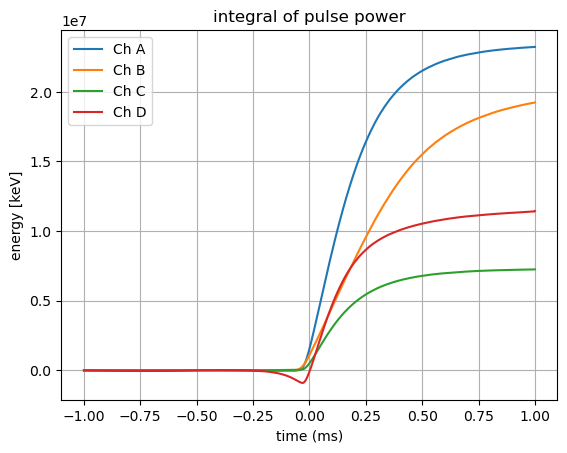

In [1583]:
# cumulative energy
plt.figure()

for c in channels:
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')

In [1584]:
for c in channels:
    print(didvfit[c][3]['smallsignalparams']['rp'])

0.07822705157001561
0.06310075746068242
0.002977813302007984
0.005101919590268619


In [1585]:
peak_energy

59.54

From [https://doi.org/10.1103/PhysRevD.104.032010](https://doi.org/10.1103/PhysRevD.104.032010) (citing Irwin & Hilton, 2005), the energy absorbed by TES can be inferred from circuit parameters, given shift in current $\delta I(t) = I_0 - I_s(t)>0$:

$$E \approx  \left(1 - \frac{2R_l}{R_l+R_0}\right) I_b R_{sh} \int \delta I(t)dt + R_l \int \delta I^2(t) dt$$



In [1586]:
didvconfig = pd.read_csv(folder_base + '/Run4/dIdV Data/20250516_config.txt', index_col = 0, header = None).to_dict()[1]

tot = 0
#plt.figure()
for c in channels:
    dI = abs(peak_positions[c]*templates[c]) # amps
    Ib = abs(didvconfig['off'+c])/1e6 # amps
    Rsh = didvconfig['rsh'] # Ohms
    

    R0 = didvfit[c][3]['smallsignalparams']['r0'] # Ohms

    Rp = didvfit[c][3]['smallsignalparams']['rp'] # Ohms
    Rl = Rsh + Rp

    #print(Rl, R0)

    R0s = np.linspace(0.02, 0.2, 1000)

    intdI = float(np.trapz(dI, ts_template))

    intdI2 = float(np.trapz(dI**2, ts_template))

    Joules = (1 - 2*Rl/(Rl+R0))*Ib*Rsh*intdI + Rl*intdI2
    
    Epeak = Joules / 1.602e-16 # keV

    #plt.plot(R0s, Epeak/peak_energy, label = c)

    tot += Epeak/peak_energy

    print(c, ':', f'{100*Epeak/peak_energy:.5g} %')

print(f'total: {100*tot:.5g}%')

A : -4.2833 %
B : -2.2518 %
C : 7.4208 %
D : 5.4392 %
total: 6.3249%


In [1587]:
dI.mean(), Ib

(np.float64(4.0665804205490177e-07), 9.690000000000001e-05)

In [1588]:
R0, Rl, Rp

(np.float64(0.047303308674271606),
 np.float64(0.02510191959026862),
 np.float64(0.005101919590268619))